In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import spacy
import numpy as np
import time
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import pandas as pd

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Script is running with GPU')
else:
  device = torch.device("cpu")
  print('Script is running WITHOUT GPU')

Script is running with GPU


In [ ]:
sents = list(np.load('OE_sents.npy', allow_pickle=True))
tags = list(np.load('OE_tags_minimal.npy', allow_pickle=True))
problems = []

In [ ]:
sents[0]

['start', 'Adrianus', 'cw+a+d', 'to', 'Ritheus', '.', 'stop']

In [ ]:
#for idx, sent in enumerate(sents):
#  sent.insert(0, 'start')
#  sent.append('stop')
#  sents[idx] = sent
#for idx, sent in enumerate(tags):
#  sent.insert(0, 'start')
#  sent.append('stop')
#  tags[idx] = sent
#for idx, sent in enumerate(tags):
#  if 'XX' in sent:
#    problems.append(idx)

In [ ]:
rawwords = []
for sent in sents:
  for word in sent:
    rawwords.append(word)

rawtags = []
for sequence in tags:
  for tag in sequence:
    rawtags.append(tag)

In [ ]:
allwords = list(set(rawwords))
alltags = list(set(rawtags))

In [ ]:
word_tokenizer = {word: idx+1 for idx, word in enumerate(allwords)}
word_decoder = {idx+1: word for idx, word in enumerate(allwords)}
tag_tokenizer = {tag: idx+1 for idx, tag in enumerate(alltags)}
tag_decoder = {idx+1: tag for idx, tag in enumerate(alltags)}

def tokenize(sentences, tokenizer):
  indexed_sentences = []
  for sentence in sentences:
    indexed_sentence = [tokenizer[word] for word in sentence]
    indexed_sentences.append(indexed_sentence)
  return indexed_sentences

encsents = tokenize(sents, word_tokenizer)
enctags = tokenize(tags, tag_tokenizer)

padsents, padtags = [], []

maxlen = max(len(sublist) for sublist in encsents)
for sublist in encsents:
  while len(sublist) < maxlen:
    sublist = sublist + [0]
    if len(sublist) == maxlen:
      break
    sublist = [0] + sublist
  padsents.append(sublist)
allenctags = []
maxlen = max(len(sublist) for sublist in enctags)
for sublist in enctags:
  for i in sublist:
    allenctags.append(i)
  while len(sublist) < maxlen:
    sublist = sublist + [0]
    if len(sublist) == maxlen:
      break
    sublist = [0] + sublist
  padtags.append(sublist)

In [ ]:
tag_mask = []
for seq in padtags:
  mask = [1]*len(seq)
  for idx, tag in enumerate(seq):
    if tag == tag_tokenizer['XX']:
      mask[idx] = 0
    if tag == tag_tokenizer['start']:
      mask[idx] = 0
    if tag == tag_tokenizer['stop']:
      mask[idx] = 0
    if tag == tag_tokenizer['PUNCT']:
      mask[idx] = 0
  tag_mask.append(mask)

In [ ]:
pad_tags_mask = []
for i in range(len(padtags)):
  pad_tags_mask.append([padtags[i], tag_mask[i]])

In [ ]:
X_test, X_train, y_test, y_train = train_test_split(padsents, pad_tags_mask, test_size=0.8)
X_train_tensor = torch.tensor(X_train, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
torch.save(train_loader, 'OETrain.pth')
torch.save(test_loader, 'OETest.pth')

In [ ]:
train_loader = torch.load('OETrain.pth', map_location=device, weights_only=False)
test_loader = torch.load('OETest.pth', map_location=device, weights_only=False)

In [ ]:
print(X_train_tensor.size())
print(y_train_tensor.size())
print(X_test_tensor.size())
print(y_test_tensor.size())

torch.Size([90128, 125])
torch.Size([90128, 2, 125])
torch.Size([22532, 125])
torch.Size([22532, 2, 125])


In [ ]:
def calculate_class_weights(y):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    print(unique_classes)
    print(class_counts)
    total_samples = len(y)
    class_weights = []
    class_weights.append(1)

    for class_label, class_count in zip(unique_classes, class_counts):
        class_weight = math.log(total_samples / (class_count))
        class_weights.append(class_weight)

    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    return class_weights

In [ ]:
class_weights = calculate_class_weights(allenctags)
print("Class weights:", class_weights)
print(len(class_weights))
print(len(alltags)+1)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 36069  12141  74684 121584   3734  14542 101892   1250   6160 272179
 108744 154240 127608  47993  36366 188729 112660 112660 316481  14731]
Class weights: tensor([1.0000, 3.9453, 5.0341, 3.2175, 2.7301, 6.2132, 4.8537, 2.9068, 7.3076,
        5.7126, 1.9243, 2.8417, 2.4922, 2.6818, 3.6597, 3.9371, 2.2904, 2.8063,
        2.8063, 1.7735, 4.8408], device='cuda:0')
21
21


In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

  def categorical_accuracy(self, preds, y, mask, tag_pad_idx = 0):
    max_preds = preds.argmax(dim = 1, keepdim = False)
    max_preds = max_preds*mask
    y = y*mask
    max_preds = torch.flatten(max_preds)
    y = torch.flatten(y)
    non_pad_elements = y.nonzero()
    correct = max_preds[non_pad_elements].eq(y[non_pad_elements])
    return correct.sum() / y[non_pad_elements].shape[0]

  def early_stop(self, validation_loss, patience = 3, min_delta = 0):
    if validation_loss < self.min_validation_loss:
        self.min_validation_loss = validation_loss
        self.patiencecount = 0
    elif validation_loss > (self.min_validation_loss + min_delta):
        self.patiencecount += 1
        print(f"Early stopping counter: {self.patiencecount} out of {patience}")
        if self.patiencecount >= patience:
            return True
    return False

  def fit(self, train_dl, val_dl, epochs, pad_idx = 0):
    optimizer = torch.optim.Adam(self.parameters(), lr = 0.001)

    self.patiencecount = 0
    self.min_validation_loss = float('inf')

    self.trainlosses = []
    self.vallosses = []

    self.train_accs = []
    self.val_accs = []

    counter = 0
    for epoch in range(epochs):
      for batch in train_dl:
        counter += 1
        text = batch[0]

        output = batch[1]
        output = output.transpose(0,1)
        tags = output[0]
        mask = output[1]
        optimizer.zero_grad()
        predictions = self.forward(text)
        predictions = predictions.transpose(1,2)
        loss = self.loss_fn(predictions, tags)
        loss = (loss * mask).sum() / mask.sum()
        loss.backward()
        optimizer.step()
      train_loss, train_acc = self.evaluate(train_dl)
      val_loss, val_acc = self.evaluate(val_dl)
      self.trainlosses.append(train_loss)
      self.vallosses.append(val_loss)
      self.train_accs.append(train_acc)
      self.val_accs.append(val_acc)
      if self.early_stop(val_loss):
        break
      train_acc = train_acc*100
      val_acc = val_acc*100
      print(f"Epoch [{epoch + 1}/{epochs}] - TrainLoss: {train_loss:.4f}, ValLoss: {val_loss:.4f}, TrainAcc: {train_acc:.2f},% ValAcc: {val_acc:.2f}%")

  def evaluate(self, val_dl, pad_idx = 0):
    losses = []
    accuracies = []
    with torch.no_grad():
      for batch in val_dl:
          text = batch[0]
          output = batch[1]
          output = output.transpose(0,1)
          tags = output[0]
          mask = output[1]
          predictions = self.forward(text)
          predictions = predictions.transpose(1,2)
          loss = self.loss_fn(predictions, tags)
          loss = (loss * mask).sum() / mask.sum()
          losses.append(loss)
          acc = self.categorical_accuracy(predictions, tags, mask, pad_idx)
          accuracies.append(acc)
    return torch.Tensor(losses).mean(), torch.Tensor(accuracies).mean()

In [ ]:
class OETagger(Model):
    def __init__(self, vocab, embeds, hidden, tagset, n_layers, dropout, criterion, pad_idx = 0):
        super().__init__()

        self.embedding = nn.Embedding(vocab, embeds, padding_idx = pad_idx, scale_grad_by_freq = True)

        self.lstm = nn.LSTM(embeds, hidden, num_layers = n_layers, bidirectional = True,
                            dropout = dropout if n_layers > 1 else 0)

        self.lin = nn.Linear(hidden * 2, tagset)

        self.dropout = nn.Dropout(dropout)

        self.loss_fn = criterion

    def forward(self, sent):
        x = self.embedding(sent)
        x, (hidden, cell) = self.lstm(x)
        x = self.lin(self.dropout(x))
        return x

In [ ]:
vocab = len(allwords)+1
n_emb = 300
n_hidden = 60
n_tags = len(alltags)+1
n_layers = 3
dropout = .2
pad_idx = 0
criterion = nn.CrossEntropyLoss(reduction = 'none', ignore_index = pad_idx).to(device)

In [ ]:
network_OETagger = OETagger(vocab, n_emb, n_hidden, n_tags, n_layers, dropout, criterion, pad_idx).to(device)

In [ ]:
%time network_OETagger.fit(train_loader, test_loader, 20)

Epoch [1/20] - TrainLoss: 0.0293, ValLoss: 0.0337, TrainAcc: 90.22,% ValAcc: 88.76%
Epoch [2/20] - TrainLoss: 0.0219, ValLoss: 0.0288, TrainAcc: 92.40,% ValAcc: 90.31%
Epoch [3/20] - TrainLoss: 0.0186, ValLoss: 0.0276, TrainAcc: 93.37,% ValAcc: 90.89%
Early stopping counter: 1 out of 3
Epoch [4/20] - TrainLoss: 0.0168, ValLoss: 0.0278, TrainAcc: 93.84,% ValAcc: 91.06%
Early stopping counter: 2 out of 3
Epoch [5/20] - TrainLoss: 0.0157, ValLoss: 0.0281, TrainAcc: 94.14,% ValAcc: 91.20%
Early stopping counter: 3 out of 3
CPU times: user 2min 17s, sys: 51.3 s, total: 3min 8s
Wall time: 3min 9s


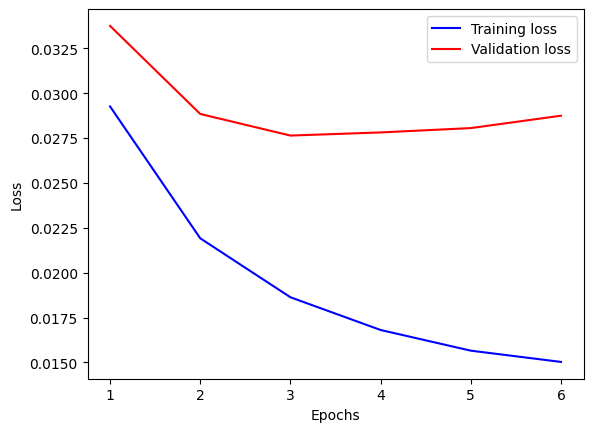

In [ ]:
epochs = range(1, len(network_OETagger.trainlosses) + 1)

plt.plot(epochs, network_OETagger.trainlosses, 'blue', label='Training loss')
plt.plot(epochs, network_OETagger.vallosses, 'red', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

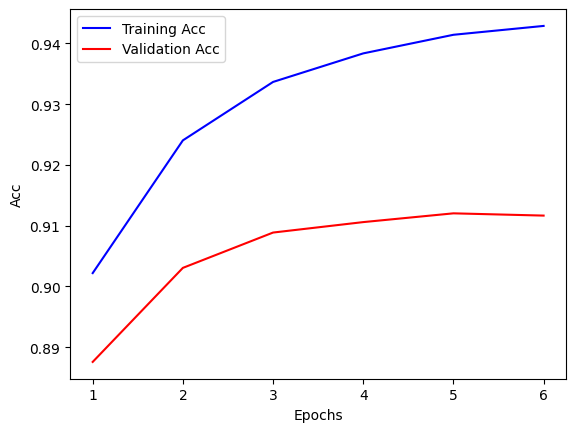

In [ ]:
epochs = range(1, len(network_OETagger.train_accs) + 1)

plt.plot(epochs, network_OETagger.train_accs, 'blue', label='Training Acc')
plt.plot(epochs, network_OETagger.val_accs, 'red', label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
def predict(model, data, pad_idx):
    with torch.no_grad():
      predicts_out = []
      tags_out = []
      text_out = []
      for batch in data:
        text = batch[0]
        output = batch[1]
        output = output.transpose(0,1)
        tags = output[0]
        mask = output[1]
        predictions = model.forward(text)
        predictions = predictions.transpose(1,2)
        predictions = predictions.argmax(dim = 1)
        for idx, sent in enumerate(text):
          predicts_out.append(np.array(predictions[idx].cpu()))
          tags_out.append(np.array(tags[idx].cpu()))
          text_out.append(np.array(sent.cpu()))
    for idx, ele in enumerate(predicts_out):
      predicts_out[idx] = predicts_out[idx].tolist()
    for idx, ele in enumerate(tags_out):
      tags_out[idx] = tags_out[idx].tolist()
    for idx, ele in enumerate(text_out):
      text_out[idx] = text_out[idx].tolist()

    return predicts_out, tags_out, text_out

In [ ]:
preds, tags, texts = predict(network_OETagger, test_loader, pad_idx)

In [ ]:
print(preds[0])
print(tags[0])

[10, 3, 19, 10, 10, 10, 3, 19, 3, 10, 19, 10, 3, 3, 19, 19, 19, 19, 19, 19, 19, 19, 10, 3, 3, 3, 3, 10, 19, 3, 10, 19, 10, 3, 19, 19, 3, 19, 3, 3, 3, 19, 19, 19, 10, 19, 19, 10, 11, 7, 4, 1, 11, 10, 10, 3, 3, 10, 4, 19, 14, 12, 4, 19, 10, 19, 11, 3, 7, 12, 14, 10, 14, 3, 19, 19, 10, 3, 19, 19, 19, 19, 19, 10, 10, 19, 10, 3, 19, 19, 10, 19, 19, 10, 19, 19, 3, 3, 10, 3, 10, 19, 3, 19, 19, 19, 19, 3, 19, 19, 19, 19, 19, 10, 19, 19, 3, 19, 10, 3, 19, 19, 19, 19, 19]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 7, 4, 1, 11, 10, 10, 16, 3, 10, 4, 19, 14, 12, 4, 19, 10, 19, 3, 16, 7, 12, 4, 10, 4, 3, 19, 16, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
for i in range(len(preds)):
  for j in range(len(preds[i])):
    if tags[i][j] == 0:
      preds[i][j] = 0
  preds[i] = [ele for ele in preds[i] if ele != 0]
  tags[i] = [ele for ele in tags[i] if ele != 0]
  texts[i] = [ele for ele in texts[i] if ele != 0]

In [ ]:
decpreds, dectags, dectext, declangs = [], [], [], []
decpreds.append(tokenize(preds, tag_decoder))
dectags.append(tokenize(tags, tag_decoder))
dectext.append(tokenize(texts, word_decoder))
decpreds = decpreds[0]
dectags = dectags[0]
dectext = dectext[0]

In [ ]:
print(decpreds[0])
print(dectags[0])
print(dectext[0])

['ADV', 'CONJ', 'D', 'Q', 'ADV', 'VB', 'VB', 'ADJ', 'ADJ', 'VB', 'D', 'N', 'C', 'P', 'D', 'N', 'VB', 'N', 'ADV', 'ADJ', 'CONJ', 'P', 'C', 'VB', 'C', 'ADJ', 'N', 'N', 'VB']
['start', 'CONJ', 'D', 'Q', 'ADV', 'VB', 'VB', 'PUNCT', 'ADJ', 'VB', 'D', 'N', 'C', 'P', 'D', 'N', 'VB', 'N', 'ADJ', 'PUNCT', 'CONJ', 'P', 'D', 'VB', 'D', 'ADJ', 'N', 'PUNCT', 'stop']
['start', 'and', '+t+as', 'ealles', 'swi+te', 'wundrigende', 'cw+a+d', ',', 'Eadige', 'synd', '+tas', 'weras', '+te', 'on', '+tisse', 'worulde', 'syndon', 'englum', 'gelice', ',', 'and', '+turh', '+t+at', 'begita+d', '+t+at', 'ece', 'lif', '.', 'stop']


In [ ]:
in_set_vocab = []
for batch in train_loader:
  texts = batch[0]
  for sent in texts:
    sent = sent.tolist()
    sent = [ele for ele in sent if ele != 0]
    x = []
    for i in sent:
      x.append([i])
    x = tokenize(x, word_decoder)
    for word in x:
      in_set_vocab.append(word)
in_set_vocab = set([x for y in in_set_vocab for x in y])

In [ ]:
corrects, incorrects, totals = [], [], []
uk_corrects, uk_incorrects, uk_totals = [], [], []
for i in range(len(decpreds)):
  for j in range(len(decpreds[i])):
    totals.append(dectags[i][j])
    if decpreds[i][j] == dectags[i][j]:
      corrects.append(decpreds[i][j])
    else:
      incorrects.append(decpreds[i][j])
    if dectext[i][j] not in in_set_vocab:
      uk_totals.append(dectags[i][j])
      if decpreds[i][j] == dectags[i][j]:
        uk_corrects.append(decpreds[i][j])
      else:
        uk_incorrects.append(decpreds[i][j])

c_freqs = Counter(corrects)
ic_freqs = Counter(incorrects)
t_freqs = Counter(totals)
uk_c_freqs = Counter(uk_corrects)
uk_ic_freqs = Counter(uk_incorrects)
uk_t_freqs = Counter(uk_totals)

print('Total Accuracy:')
data = []
labels = []
any_c = [x[0] for x in c_freqs.most_common()]
for i in t_freqs.most_common():
  if i[0] not in any_c:
    data.append(0)
    labels.append(i[0])
    print(f'{i[0]} | 0% of {i[1]}')
  else:
    for ele in c_freqs.most_common():
      if ele[0] == i[0]:
        num_c = ele[1]
    class_acc = num_c/i[1]
    data.append(class_acc*100)
    labels.append(i[0])
    print(f'{i[0]} | {class_acc*100:.2f}% of {i[1]}')

Total Accuracy:
N | 93.76% of 63929
VB | 91.94% of 54609
PUNCT | 0% of 37861
P | 89.00% of 31121
PRO | 94.80% of 25662
D | 84.08% of 24322
start | 0% of 22532
stop | 0% of 22532
ADV | 84.63% of 21970
CONJ | 94.11% of 20561
ADJ | 85.48% of 15059
C | 95.79% of 9604
PRO$ | 97.28% of 7323
Q | 95.18% of 7310
NUM | 94.88% of 2889
XX | 0% of 2644
NEG | 99.96% of 2430
PART | 64.08% of 1264
WH | 90.71% of 732
INTJ | 87.88% of 231


In [ ]:
plot_list = ['N', 'VB', 'P', 'PRO', 'D', 'ADV', 'CONJ', 'ADJ', 'C', 'PRO$', 'Q', 'NUM', 'NEG', 'PART', 'WH', 'INTJ']

In [ ]:
print(labels)

['N', 'VB', 'PUNCT', 'P', 'PRO', 'D', 'start', 'stop', 'ADV', 'CONJ', 'ADJ', 'C', 'PRO$', 'Q', 'NUM', 'XX', 'NEG', 'PART', 'WH', 'INTJ']


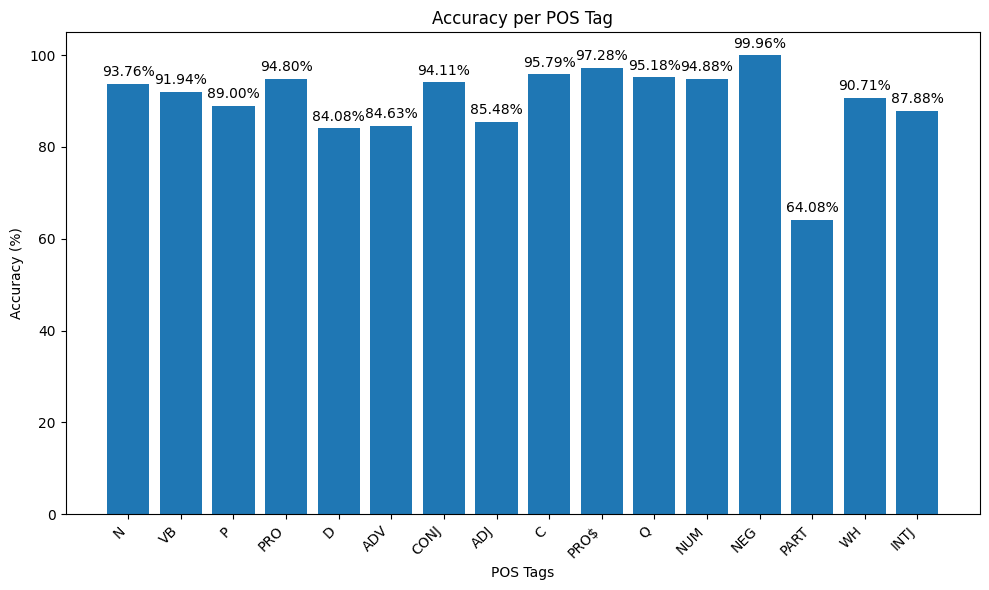

In [ ]:
plot_data = []
plot_labels = []
for label, value in zip(labels, data):
    if label in plot_list:
        plot_data.append(value)
        plot_labels.append(label)

plt.figure(figsize=(10, 6))
plt.bar(plot_labels, plot_data)
plt.xlabel("POS Tags")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per POS Tag")
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(plot_data):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()
